## Step1: Put all libraries and packages at top

In [12]:
# for updating the custom imports
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Built-in imports

In [13]:
# built-in imports
import os
import sys
import time
import random

### Standard imports

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# working with images
import cv2
import imageio as iio

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F

# torchvision
import torchvision
import torchvision.transforms as transforms

# torchsummary
import torchsummary

# interactive progress bar
from tqdm import notebook

from IPython.display import clear_output

### Custom imports

In [15]:
sys.path.insert(0, '..')

# losses
from utils.metrics import iou_pytorch_eval, IoULoss, IoUBCELoss
from utils.metrics import iou_pytorch_test, dice_pytorch_test, precision_pytorch_test, recall_pytorch_test, fbeta_pytorch_test, accuracy_pytorch_test

# dataset
from utils.dataset import myDataSet

# transforms
from utils.transforms import SIZE, resize_transform, train_transforms, test_transforms

sys.path.insert(0, './notebooks')

In [16]:
sys.path.insert(0, '..')

# models
from models.unet import UNet, UNet_attention

sys.path.insert(0, './notebooks')

## Step 2: Fix a seed for reproducibility, and choose the DEVICE

In [10]:
random_seed= 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [11]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # select device for training, i.e. gpu or cpu
print(DEVICE)

cuda


## Step 3: Set your transforms, e.g, normalisation, resizing, rotation, flip, padding etc

In [12]:
print(SIZE)
print(resize_transform)
print(train_transforms)
print(test_transforms)

(256, 256)
Resize(size=(256, 256), interpolation=nearest, max_size=None, antialias=None)
Compose(
    Resize(size=(256, 256), interpolation=nearest, max_size=None, antialias=None)
    RandomRotation(degrees=[-180.0, 180.0], interpolation=nearest, expand=False, fill=0)
    RandomHorizontalFlip(p=0.5)
    RandomCrop(size=(256, 256), padding=10)
)
Compose(
    Resize(size=(256, 256), interpolation=nearest, max_size=None, antialias=None)
)


## Step 4: Make your train and validation data loader with option to use different preprocessing

In [13]:
path_images = "../data/train-val/images"
path_masks = "../data/train-val/masks"


# pre-defined split
with open('../train-val-split/train.txt', 'r') as f:
    ids_train = [l.strip()+'.jpg' for l in f]
with open('../train-val-split/val.txt', 'r') as f:
    ids_val = [l.strip()+'.jpg' for l in f]


# no augmentation - like in test transform
custom_dataset_train = myDataSet(ids_train, path_images, path_masks, transforms=test_transforms)
custom_dataset_valid = myDataSet(ids_val, path_images, path_masks, transforms=test_transforms)

print("My custom training-dataset has {} elements".format(len(custom_dataset_train)))
print("My custom validation-dataset has {} elements".format(len(custom_dataset_valid)))

My custom training-dataset has 880 elements
My custom validation-dataset has 120 elements


In [51]:
BATCH_SIZE = 12

# Create dataloaders from datasets with the native pytorch functions
dataloader_train = torch.utils.data.DataLoader(custom_dataset_train, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
dataloader_valid = torch.utils.data.DataLoader(custom_dataset_valid, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

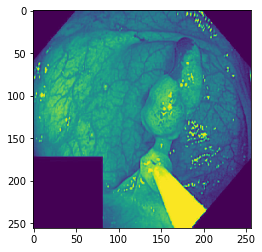

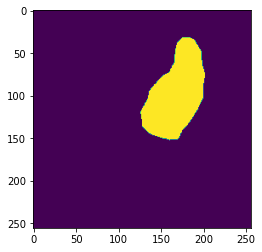

In [52]:
# Show example images.
image_number = 23
img, mask = custom_dataset_train.__getitem__(image_number)


# image
plt.figure()
plt.imshow(img.mean(0)) # 3 channels, take mean

# mask
plt.figure()
plt.imshow(mask[0, :, :]) # 1 channel, take it

plt.show()

In [53]:
custom_dataset_train.__getitem__(image_number)[0].shape

torch.Size([3, 256, 256])

In [54]:
custom_dataset_train.__getitem__(image_number)[1].shape, np.unique(custom_dataset_train.__getitem__(image_number)[1])

(torch.Size([1, 256, 256]), array([0., 1.], dtype=float32))

# Training hyperparameters

In [55]:
# Begin training
model = UNet(channel_in=3, channel_out=1)
model = model.to(DEVICE) # load model to DEVICE

In [56]:
# Define variables for the training
epochs = 100
patience = 10

In [57]:
# Define optimiser and criterion for the training. You can try different ones to see which works best for your data and task
optimiser = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-8)

criterion = IoULoss()
model_name = 'UNet_IoULoss_baseline'

# criterion = nn.BCEWithLogitsLoss()
# model_name = 'UNet_BCEWithLogitsLoss_baseline'

# criterion = IoUBCELoss()
# model_name = 'UNet_IoUBCELoss_baseline'


# Training

In [58]:
%%time

train_losses = []
val_losses = []
best_iou = 0
best_loss = np.Inf
best_epoch = -1
state = {}


for epoch in range(epochs):
    running_loss = 0
    running_iou = 0
    # Train
    model.train()
    for i, (imgs, masks) in enumerate(dataloader_train):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        
        optimiser.zero_grad()
        loss = criterion(prediction, masks)
        loss.backward()
        optimiser.step()
        
        running_loss += loss.item()
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}".format(epoch, epochs, i, len(dataloader_train), running_loss/(i+1)), end="")
        
        running_iou += iou_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, IoU:  {:.6f}".format(epoch, epochs, i, len(dataloader_train), running_iou/(i+1)), end="")
        
    # Validate
    model.eval()
    val_loss = 0
    val_iou = 0
    for i, (imgs, masks) in enumerate(dataloader_valid):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        loss = criterion(prediction, masks)
        val_loss += loss.item()
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, Val. Loss: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), val_loss/len(dataloader_train), val_loss/(i+1)), end="")
        
        val_iou += iou_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, IoU: {:.6f}, Val. IoU: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), val_iou/len(dataloader_train), val_iou/(i+1)), end="")
    
    
    # compute overall epoch losses
    epoch_train_loss = running_loss/len(dataloader_train)
    train_losses.append(epoch_train_loss)
    epoch_val_loss = val_loss/len(dataloader_valid)
    val_losses.append(epoch_val_loss)
    # compute overall epoch iou-s
    epoch_train_iou = running_iou/len(dataloader_train)
    epoch_val_iou = val_iou/len(dataloader_valid)
    
    print("\r Epoch: {} of {}, Iter.: {} of {}, Train Loss: {:.6f}, IoU: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_train_loss, epoch_train_iou))
    print("\r Epoch: {} of {}, Iter.: {} of {}, Valid Loss: {:.6f}, IoU: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_val_loss, epoch_val_iou))
    
    
    # plot
    plt.figure(figsize=(18, 9))
    plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train, loss: {epoch_train_loss:.4f}, IoU: {epoch_train_iou:.4f}', linewidth=3)
    plt.plot(np.arange(len(val_losses)), val_losses, label=f'Valid, loss: {epoch_val_loss:.4f}, IoU: {epoch_val_iou:.4f}', linewidth=3)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Epoch {epoch}')
    plt.legend(loc='best')
    plt.show()
    
    # save if best results or break is has not improved for {patience} number of epochs
    best_iou = max(best_iou, epoch_val_iou)
    best_loss = min(best_loss, epoch_val_loss)
    best_epoch = epoch if best_iou == epoch_val_iou else best_epoch
    
    # record losses
    state['train_losses'] = train_losses
    state['val_losses'] = val_losses
    
    if best_epoch == epoch:
        # print('Saving..')
        state['net'] = model.state_dict()
        state['iou'] = best_iou
        state['epoch'] = epoch
            
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, f'../checkpoints/ckpt_{model_name}.pth')
    
    elif best_epoch + patience < epoch:
        print(f"\nEarly stopping. Target criteria has not improved for {patience} epochs.\n")
        break
        
        
# load once more and write all the losses down (othw can miss the last 10)
state = torch.load(f'../checkpoints/ckpt_{model_name}.pth')
state['train_losses'] = train_losses
state['val_losses'] = val_losses
torch.save(state, f'../checkpoints/ckpt_{model_name}.pth')

print(best_epoch, best_iou)

RuntimeError: CUDA out of memory. Tried to allocate 192.00 MiB (GPU 0; 10.76 GiB total capacity; 8.94 GiB already allocated; 60.56 MiB free; 9.66 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## Evaluate validation performance (256*256 images)

In [ ]:
%ls ../checkpoints

In [ ]:
# make a model and put on device
model = UNet(channel_in=3, channel_out=1)
model = model.to(DEVICE) # load model to DEVICE

# load best weights and put into the evaluation mode
print(model_name)
model.load_state_dict(torch.load(f'../checkpoints/ckpt_{model_name}.pth')['net'])

In [ ]:
print('Best epoch:', torch.load(f'../checkpoints/ckpt_{model_name}.pth')['epoch'])
print(f'Validation IoU ({SIZE[0]}x{SIZE[1]}):', torch.load(f'../checkpoints/ckpt_{model_name}.pth')['iou'].item())

## TODO: Pipeline

In [ ]:
# def train(model, optim, criterion, dataloader, epoch, device):
#     pass

In [ ]:
# def test(model, criterion, dataloader, epoch, device, best_acc, model_name='model'):
#     pass

In [ ]:
# # Begin training
# model = UNet(channel_in=3, channel_out=1)
# model = model.to(DEVICE)

# train_losses = []
# test_losses = []
# best_iou = 0
# best_epoch = -1

# for epoch in notebook.tqdm(range(30)):
#     train_loss, train_iou = train(model, optimiser, criterion, dataloader_train, epoch, DEVICE)
#     train_losses.append(train_loss)
    
#     test_loss, test_iou = test(model, criterion, dataloader_valid, epoch, DEVICE, best_iou, model_name='Unet_BCEWithLogitsLoss')
#     #scheduler.step(test_loss) # not always needed
#     test_losses.append(test_loss)
    
#     best_iou = max(best_iou, test_iou)
#     best_epoch = epoch if best_iou == test_iou else best_epoch

#     clear_output()
    
#     plt.figure(figsize=(18, 9))
#     plt.plot(np.arange(len(train_losses)), train_losses, label=f'Train, loss: {train_loss:.4f}, IoU: {train_iou}%')
#     plt.plot(np.arange(len(test_losses)), test_losses, label=f'Test, loss: {test_loss:.4f}, IoU: {test_iou}%')
#     plt.title(f'Epoch {epoch}')
#     plt.legend(loc='best')
#     plt.show()